In [6]:
'''
This is a simple implementation of the predictive coding model of perception.
'''

# Import the necessary modules, I'm going to use torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model
class PredictiveCodingLayer(nn.Module):

    def __init__(self, input_size, n_causes=32, kernel_size=16, stride=5, padding=0, k1=0.1, k2=0.1, sigma2=1, alpha=0.1, lam=0.1):
        '''
        This is the initialization function for a predictive coding layer.

        input_size: the size of the full input image (channels, height, width)
        n_causes: the number of causes we use as a basis to predict the image
        kernel_size: the size of the patches, can be a single integer or a tuple (height, width)
        stride: the stride of the patches, can be a single integer or a tuple (height, width)
        padding: the padding of the patches, can be a single integer or a tuple (height, width)
        k1: the learning rate for r
        k2: the learning rate for U
        sigma2: the variance of the noise
        alpha: weight on the r prior
        lam: weight on the U prior
        '''
        super(PredictiveCodingLayer, self).__init__()

        self.input_size = input_size # (channels, height, width)
        self.n_causes = n_causes

        # process the patch parameters
        self.kernel_size, self.stride, self.padding = self.process_patch_params(kernel_size, stride, padding)

        # create the unfold layer, this will be used to extract patches from the image
        self.unfold = nn.Unfold(self.kernel_size, stride=self.stride, padding=self.padding)
        self.n_patches = self.unfold(torch.zeros(1, *input_size)).shape[2]
        self.n_patches_height, self. n_patches_width = self.compute_patch_shape()
        #self.fold = nn.Fold(output_size, kernel_size, stride, padding)

        # set the learning rates and other parameters
        self.k1 = k1 # the learning rate for r
        self.k2 = k2 # the learning rate for U
        self.sigma2 = sigma2 # the variance of the noise
        self.alpha = alpha # weight on the r prior
        self.lam = lam # weight on the U prior
        self.precision = 1/sigma2

        # set the priors on r and U
        # have an L2 prior on U
        # we can use the MSE loss for this, since it is just the L2 loss
        # but we need it to take one input, so the target should be fixed at zero
        # we can do this by using a lambda function
        self.U_prior = lambda x: F.mse_loss(x, torch.zeros_like(x))
        self.r_prior = lambda x: F.mse_loss(x, torch.zeros_like(x))

        # initialize the losses
        self.reconstruction_loss = 0
        self.r_prior_loss = 0
        self.U_prior_loss = 0
        self.total_loss = 0

        # initialize the causes and the activations
        self.U = nn.Parameter(torch.randn(n_causes, input_size[0], self.kernel_size[0], self.kernel_size[1]))
        self.r = nn.Parameter(torch.randn(1, n_causes, self.n_patches_height, self.n_patches_width)) # (batch_size, n_causes, n_patches_height, n_patches_width)

        # we initialize the batch size to 1, but it will change when we get a new image
        self.batch_size = 1

        print('number of patches is', self.n_patches, 'number of patches height is', self.n_patches_height, 'number of patches width is', self.n_patches_width, 'mult' , self.n_patches_height*self.n_patches_width)
    
    def process_patch_params(self, kernel_size, stride, padding):
        # if these are single integers, then we need to make them tuples
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)
        return kernel_size, stride, padding

    def compute_patch_shape(self):
        '''
        This function computes the shape of the patches
        '''
        # calculate the number of patches in the height and width
        # based on the formula from https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html
        # (spatial_size[d]+2×padding[d]−dilation[d]×(kernel_size[d]−1)−1)/stride[d]+1
        # if padding, kernel_size or stride are ints then they are used for both height and width
        n_patches_height = (self.input_size[1]+2*self.padding[0]-(self.kernel_size[0]-1)-1)/self.stride[0]+1
        n_patches_width = (self.input_size[2]+2*self.padding[1]-(self.kernel_size[1]-1)-1)/self.stride[1]+1

        # take the floor
        n_patches_height = int(n_patches_height)
        n_patches_width = int(n_patches_width)
        
        # make sure that n_patches_height and n_patches_width are integers and they multipy to n_patches
        assert n_patches_height*n_patches_width == self.n_patches

        return n_patches_height, n_patches_width

    def set_r(self, r):
        '''
        This function sets the value of r
        r is the state of the causes (batch_size, causes, n_patches_height, n_patches_width)
        '''
        self.r.data = r
        
    def forward(self, x):
        '''
        This is the forward function for the model.
        x is an image of size (batch_size, channels, height, width)
        r is the state of the causes (batch_size, causes, n_patches_height, n_patches_width)
        '''

        # set the batch size
        self.batch_size = x.shape[0]

        # first, get the image patches
        patches = self.unfold(x) # (batch_size, channels*kernel_size*kernel_size, num_patches)
        # now reshape the patches to be (batch_size, channels, kernel_size_height, kernel_size_width, num_patches)
        # print the shape of U and r
        print('shape of U is', self.U.shape, 'shape of r is', self.r.shape)
        print('they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)')
        # print the number of dimensions of U and r
        print('number of dimensions of U is', len(self.U.shape), 'number of dimensions of r is', len(self.r.shape))
        patches = patches.view(self.batch_size, self.input_size[0], self.kernel_size[0], self.kernel_size[1], self.n_patches_height, self.n_patches_width)
        # patches shape is (batch_size, channels, kernel_size_height, kernel_size_width, n_patches_height, n_patches_width)
        # make a prediction for every patch
        #prediction = einsum('causes chan kernh kernw, batch causes npatchesh npatchesw -> batch chan kernh kernw npatchesh npatchesw', U, r) 

        # I want to make a prediction for every patch, so I need to combine U by r
        # U is (causes, channels, kernel_size_height, kernel_size_width)
        # r is (batch_size, causes, n_patches_height, n_patches_width)
        # I want to combine them so that I get a prediction for every patch
        # I want the output to be (batch_size, channels, kernel_size_height, kernel_size_width, n_patches_height, n_patches_width)
        # use einsum
        prediction = einsum('causes chan kernh kernw, batch causes npatchesh npatchesw -> batch chan kernh kernw npatchesh npatchesw', self.U, self.r)

        #prediction = torch.einsum('cchw,bnphw->bncchwphw', U, r)


        # calculate the reconstruction loss
        prediction_error = patches - prediction
        self.reconstruction_loss = self.precision*torch.norm(prediction_error)**2

        # calculate the prior losses
        self.U_prior_loss = self.lam*self.U_prior(self.U)
        self.r_prior_loss = self.alpha*self.r_prior(self.r)

        # calculate the total loss
        self.total_loss = self.reconstruction_loss + self.U_prior_loss + self.r_prior_loss

        # reshape self.r to be (batch_size, causes, patches_x, patches_y), to send to next level
        self.r.data = self.r.view(self.batch_size, self.n_causes, self.n_patches_height, self.n_patches_width)


        return self.r


# now we want to create another custom module that takes multiple PredictiveCodingLayer modules and combines them
# we should be able to specify the number of layers and the number of causes in each layer
# we should also be able to give either single numbers or lists of numbers for the parameters of each layer
# so for instance, if there are 3 layers, then we can specify the kernel size by giving a single number or a list of 3 numbers, or a list of 3 tuples
class PredictiveCodingNetwork(nn.Module):
    def __init__(self, input_size, n_layers, n_causes, kernel_size=3, stride=1, padding=0, lam=1, alpha=1, precision=1):
        super(PredictiveCodingNetwork, self).__init__()
        # input_size is the size of the input images (channels, height, width)
        # n_layers is the number of layers in the network
        # n_causes is the number of causes in each layer (can be a single number or a list of numbers)
        # kernel_size is the size of the patches (can be a single number or a list of numbers)
        # stride is the stride of the patches (can be a single number or a list of numbers)
        # padding is the padding of the patches (can be a single number or a list of numbers)
        # lam is the regularization parameter for the U prior (can be a single number or a list of numbers)
        # alpha is the regularization parameter for the r prior (can be a single number or a list of numbers)
        # precision is the precision of the reconstruction loss (can be a single number or a list of numbers)

        # first, we need to make sure that the parameters are lists
        # if the parameters are single numbers, then we need to make them lists
        if isinstance(n_causes, int):
            n_causes = [n_causes]*n_layers
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size]*n_layers
        if isinstance(stride, int):
            stride = [stride]*n_layers
        if isinstance(padding, int):
            padding = [padding]*n_layers
        if isinstance(lam, int):
            lam = [lam]*n_layers
        if isinstance(alpha, int):
            alpha = [alpha]*n_layers
        if isinstance(precision, int):
            precision = [precision]*n_layers

        # now we need to make sure that the lists are the correct length
        assert len(n_causes) == n_layers
        assert len(kernel_size) == n_layers
        assert len(stride) == n_layers
        assert len(padding) == n_layers
        assert len(lam) == n_layers
        assert len(alpha) == n_layers
        assert len(precision) == n_layers

        # now we can create the layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            # create the layer
            layer = PredictiveCodingLayer(input_size, n_causes[i], kernel_size[i], stride[i], padding[i], lam[i], alpha[i], precision[i])
            # add the layer to the list of layers
            self.layers.append(layer)
            # update the input size. the input size for the next layer is the output size of the previous layer
            # which is the number of causes in the previous layer, the number of patches in the x direction, and the number of patches in the y direction
            input_size = (n_causes[i], layer.n_patches_height, layer.n_patches_width)

    def compute_total_loss(self):
        # compute the total loss by summing the total loss of each layer
        total_loss = 0
        for layer in self.layers:
            total_loss += layer.total_loss
        return total_loss

    def forward_one_timestep(self, x):
        # x is the input image, of size (batch_size, channels, height, width)

        # run the network for one timestep
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x, timesteps=1, train_U=False, r_init=None):
        # x is the input image, of size (batch_size, channels, height, width)
        # timesteps is the number of timesteps to run the network for
        # r is the initial value of r, of size (batch_size, causes, patches_x, patches_y) for each layer

        # if r_init is not none, make sure it's the right shape, which should be a list n_layers long, where each element is of size
        #  (batch_size, causes, patches_x, patches_y), if not throw a descriptive error
        if r_init is not None:
            assert len(r_init) == len(self.layers)
            for i in range(len(r_init)):
                assert r_init[i].shape == (x.shape[0], self.layers[i].n_causes, self.layers[i].n_patches_height, self.layers[i].n_patches_width)
                layer.set_r(r_init[i])
        else: # otherwise, initialize r to be random
            r_init = []
            for layer in self.layers:
                layer.set_r(torch.randn(x.shape[0], layer.n_causes, layer.n_patches_height, layer.n_patches_width))


        # run the network for the specified number of timesteps
        for i in range(timesteps):
            
            # run the network for one timestep
            x = self.forward_one_timestep(x)

            # compute the total loss
            total_loss = self.compute_total_loss()
            print('timestep: {}, total_loss: {}'.format(i, total_loss))

            # take gradients
            total_loss.backward()

            # compute the gradient of U and r
            #U_grads = [layer.U.grad for layer in self.layers]
            #r_grads = [layer.r.grad for layer in self.layers]

            # update U and r
            U_ups, r_ups = [], []
            for layer in self.layers:
                # update r
                layer.r.data -= layer.k1/2*layer.r.grad
                # update U
                if train_U:
                    layer.U.data -= layer.k2/2*layer.U.grad

            # now zero the gradient of the model
            self.zero_grad()

        return x



# make a predictive coding network with 3 layers
model = PredictiveCodingNetwork(input_size=(1, 512, 512),n_layers=3, n_causes=[32, 64, 128], kernel_size=[16, 4, 2], stride=[5, 2, 2], padding=0)

# run the network for 1 timestep
# with a batch of 2 images
x = images[:, :, 0:2].astype(np.float32)
x = torch.Tensor(x).contiguous().view(2, 1, 512, 512) # (2, 1, 512, 512) which is (batch_size, channels, height, width)
x = model(x, timesteps=50)



number of patches is 10000 number of patches height is 100 number of patches width is 100 mult 10000
number of patches is 2401 number of patches height is 49 number of patches width is 49 mult 2401
number of patches is 576 number of patches height is 24 number of patches width is 24 mult 576
shape of U is torch.Size([32, 1, 16, 16]) shape of r is torch.Size([2, 32, 100, 100])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4
shape of U is torch.Size([64, 32, 4, 4]) shape of r is torch.Size([2, 64, 49, 49])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4
shape of U is torch.Size([128, 64, 2, 2]) shape of r is torch.Size([2, 128, 24, 24])
they should be (causes, channels, kernel_size_height, kernel_si

RuntimeError: shape '[2, 1, 16, 16, 100, 100]' is invalid for input of size 262144

In [2]:
# load library
import scipy.io
import scipy.ndimage
import numpy as np
import matplotlib.pyplot as plt

IMAGE_FOLDER = './RaoBallardImages/'

# load the .mat file in the folder, shape is (512, 512, 10) which is (height, width, number of images)
images = scipy.io.loadmat(IMAGE_FOLDER + 'IMAGES_RAW.mat')['IMAGESr']

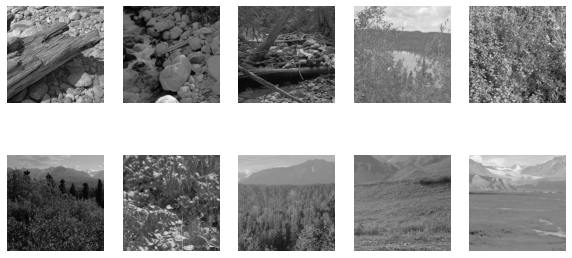

In [3]:
# load the images in a grid, 2 rows of 5 images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images[:, :, i*5+j], cmap='gray')
        ax[i, j].axis('off')

In [4]:

from fancy_einsum import einsum
model = PredictiveCodingLayer(input_size=(1, 512, 512), n_causes=32, kernel_size=16, stride=5, padding=0)
x = images[:, :, 0].astype(np.float32)
x = torch.Tensor(x).view(1, 1, 512, 512) # (1, 1, 512, 512) which is (batch_size, channels, height, width)

r_init = torch.randn(1, 32, 512, 512) # (1, 32, 512, 512) which is (batch_size, causes, height, width)

model(x).shape # (batch_size, channels*height*width, n_patches)
n_patches = model(x).shape[2]
# U is going to be n_cause, channels*heigt*width = 32, 256
U = torch.randn(32, 256)

# r is going to be n_causes,1 = 32, 1
r = torch.randn(32, 1, n_patches)

# now we want to apply U to r such that we get a matrix of size 1, 256, n_patches
# using einsum
# print the number of dimensions of U and r
xprediction = einsum('causes pixels, causes channels patches -> channels pixels patches', U, r) # (1, 256, n_patches)

# now we want to fold this back to the image
fold = nn.Fold((512, 512),16, 5, 0)
fold(prediction).shape # (1, 1, 512, 512)

# now we want to plot the image
plt.imshow(fold(prediction).view(512, 512).detach().numpy(), cmap='gray')




number of patches is 10000 number of patches height is 100 number of patches width is 100 mult 10000
shape of U is torch.Size([32, 1, 16, 16]) shape of r is torch.Size([1, 32, 100, 100])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4
shape of U is torch.Size([32, 1, 16, 16]) shape of r is torch.Size([1, 32, 100, 100])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4


NameError: name 'prediction' is not defined

In [ ]:
prediction.shape

torch.Size([1, 256, 190969])

In [ ]:
model.n_patches, model.n_patches_height, model.n_patches_width, model.n_patches_height*model.n_patches_width

(10000, 100, 100, 10000)

In [ ]:
np.sqrt(model.n_patches)

100.0

In [ ]:
model.fold.output_size

AttributeError: 'PredictiveCodingLayer' object has no attribute 'fold'

In [ ]:
# make a predictive coding network with 3 layers
model = PredictiveCodingNetwork(input_size=(1, 512, 512),n_layers=3, n_causes=[32, 64, 128], kernel_size=[16, 4, 2], stride=[5, 2, 2], padding=0)

# run the network for 1 timestep
# with a batch of 2 images
x = images[:, :, 0:2].astype(np.float32)
x = torch.Tensor(x).contiguous().view(2, 1, 512, 512) # (2, 1, 512, 512) which is (batch_size, channels, height, width)
x = model(x, timesteps=50)




number of patches is 10000 number of patches height is 100 number of patches width is 100 mult 10000
number of patches is 2401 number of patches height is 49 number of patches width is 49 mult 2401
number of patches is 576 number of patches height is 24 number of patches width is 24 mult 576
shape of U is torch.Size([32, 1, 16, 16]) shape of r is torch.Size([2, 32, 100, 100])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4
shape of U is torch.Size([64, 32, 4, 4]) shape of r is torch.Size([2, 64, 49, 49])
they should be (causes, channels, kernel_size_height, kernel_size_width) and (batch_size, causes, n_patches_height, n_patches_width)
number of dimensions of U is 4 number of dimensions of r is 4
shape of U is torch.Size([128, 64, 2, 2]) shape of r is torch.Size([2, 128, 24, 24])
they should be (causes, channels, kernel_size_height, kernel_si

RuntimeError: shape '[2, 1, 16, 16, 100, 100]' is invalid for input of size 262144

In [5]:
2*16*16*100*100

5120000